2024-10-25 14:10:37.852398: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 14:10:38.005801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 14:10:38.063190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 14:10:38.079869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 14:10:38.181996: I tensorflow/core/platform/cpu_feature_guar

Found 1650 files belonging to 2 classes.
Using 1320 files for training.
Found 1650 files belonging to 2 classes.
Using 330 files for validation.
Index(['filepath', 'label'], dtype='object')


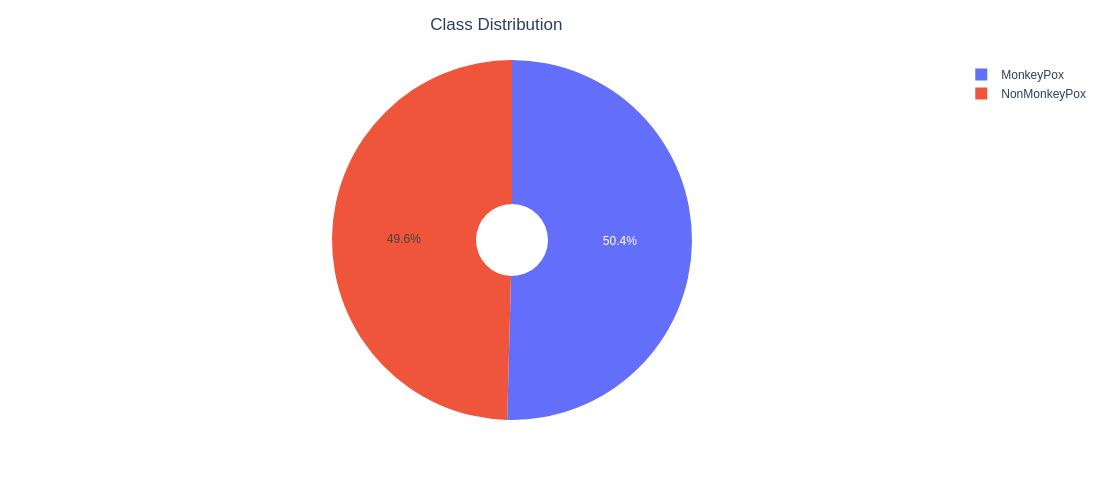

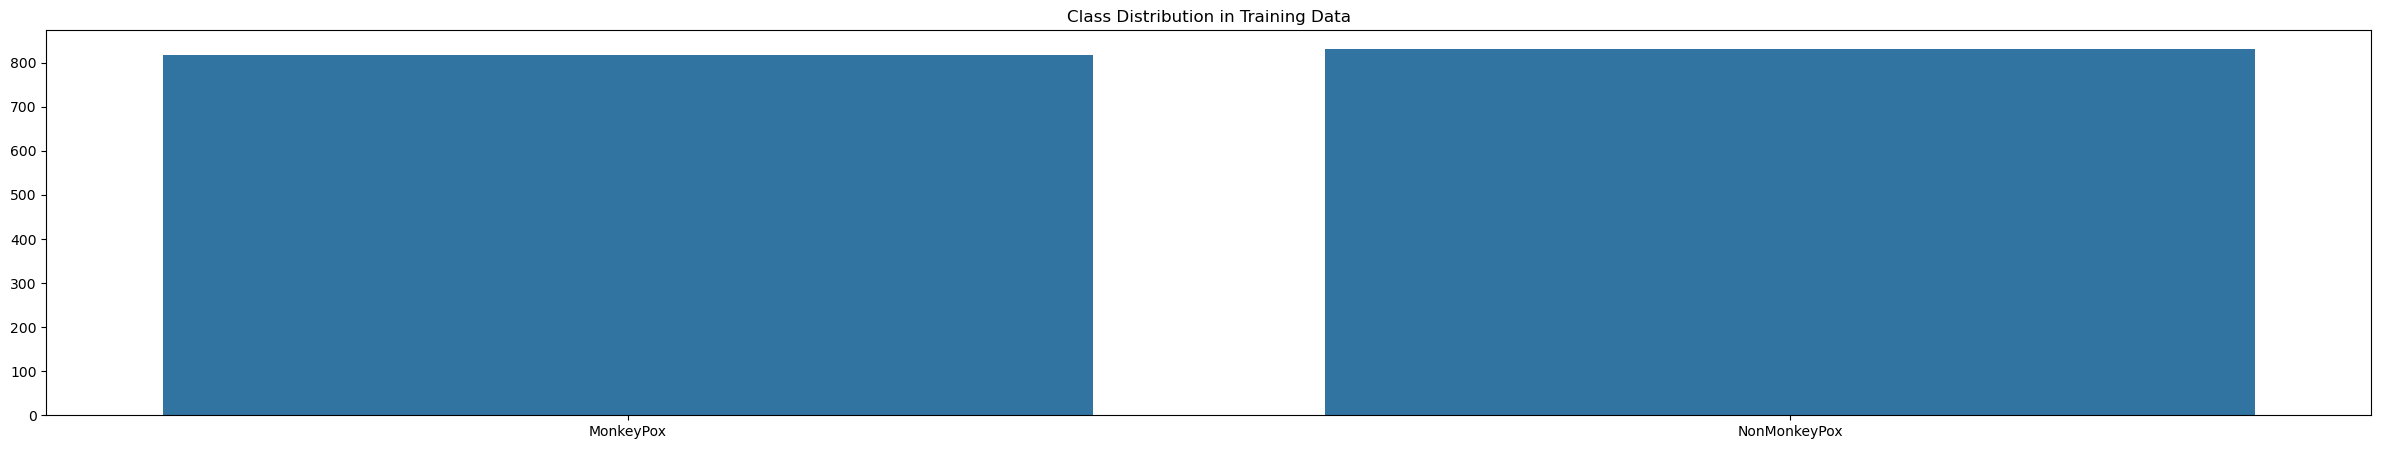

In [1]:
# Required Libraries
import numpy as np 
import pandas as pd 
import os
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Optional - Install Plotly if not already installed
# !pip install plotly

# Plotly for visualization
import plotly.express as px

# Define image dimensions and batch size
image_height = 224
image_weight = 224
batch_size = 32

# Specify the path to your dataset
tpath = 'aug'  # Update this with your local path

# Load the training data using ImageDataGenerator
training_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

# Load the validation data
validation_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

# Load the metadata information (Update the path)
info_file = 'labels_aug.csv'  # Update the path
info = pd.read_csv(info_file)
info.head()

# Check the column names to be sure
print(info.columns)

# Correct the pie chart code to use the lowercase 'label'
fig = px.pie(
    names=info['label'].unique(),  # Corrected to 'label'
    values=info['label'].value_counts(),  # Corrected to 'label'
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title': {'text': 'Class Distribution', 'x': 0.45}})
fig.show()

# Visualize class distribution in a bar plot
class_names = []
class_count = []
train_examples = 0

# Count the number of images per class
for f in os.listdir(tpath):
    files = gb.glob(pathname=str(tpath + "//" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)

# Display class distribution as a bar plot
plt.figure(figsize=(30, 5))
sns.barplot(x=class_names, y=class_count)
plt.title("Class Distribution in Training Data")
plt.show()


Found 1321 images belonging to 2 classes.


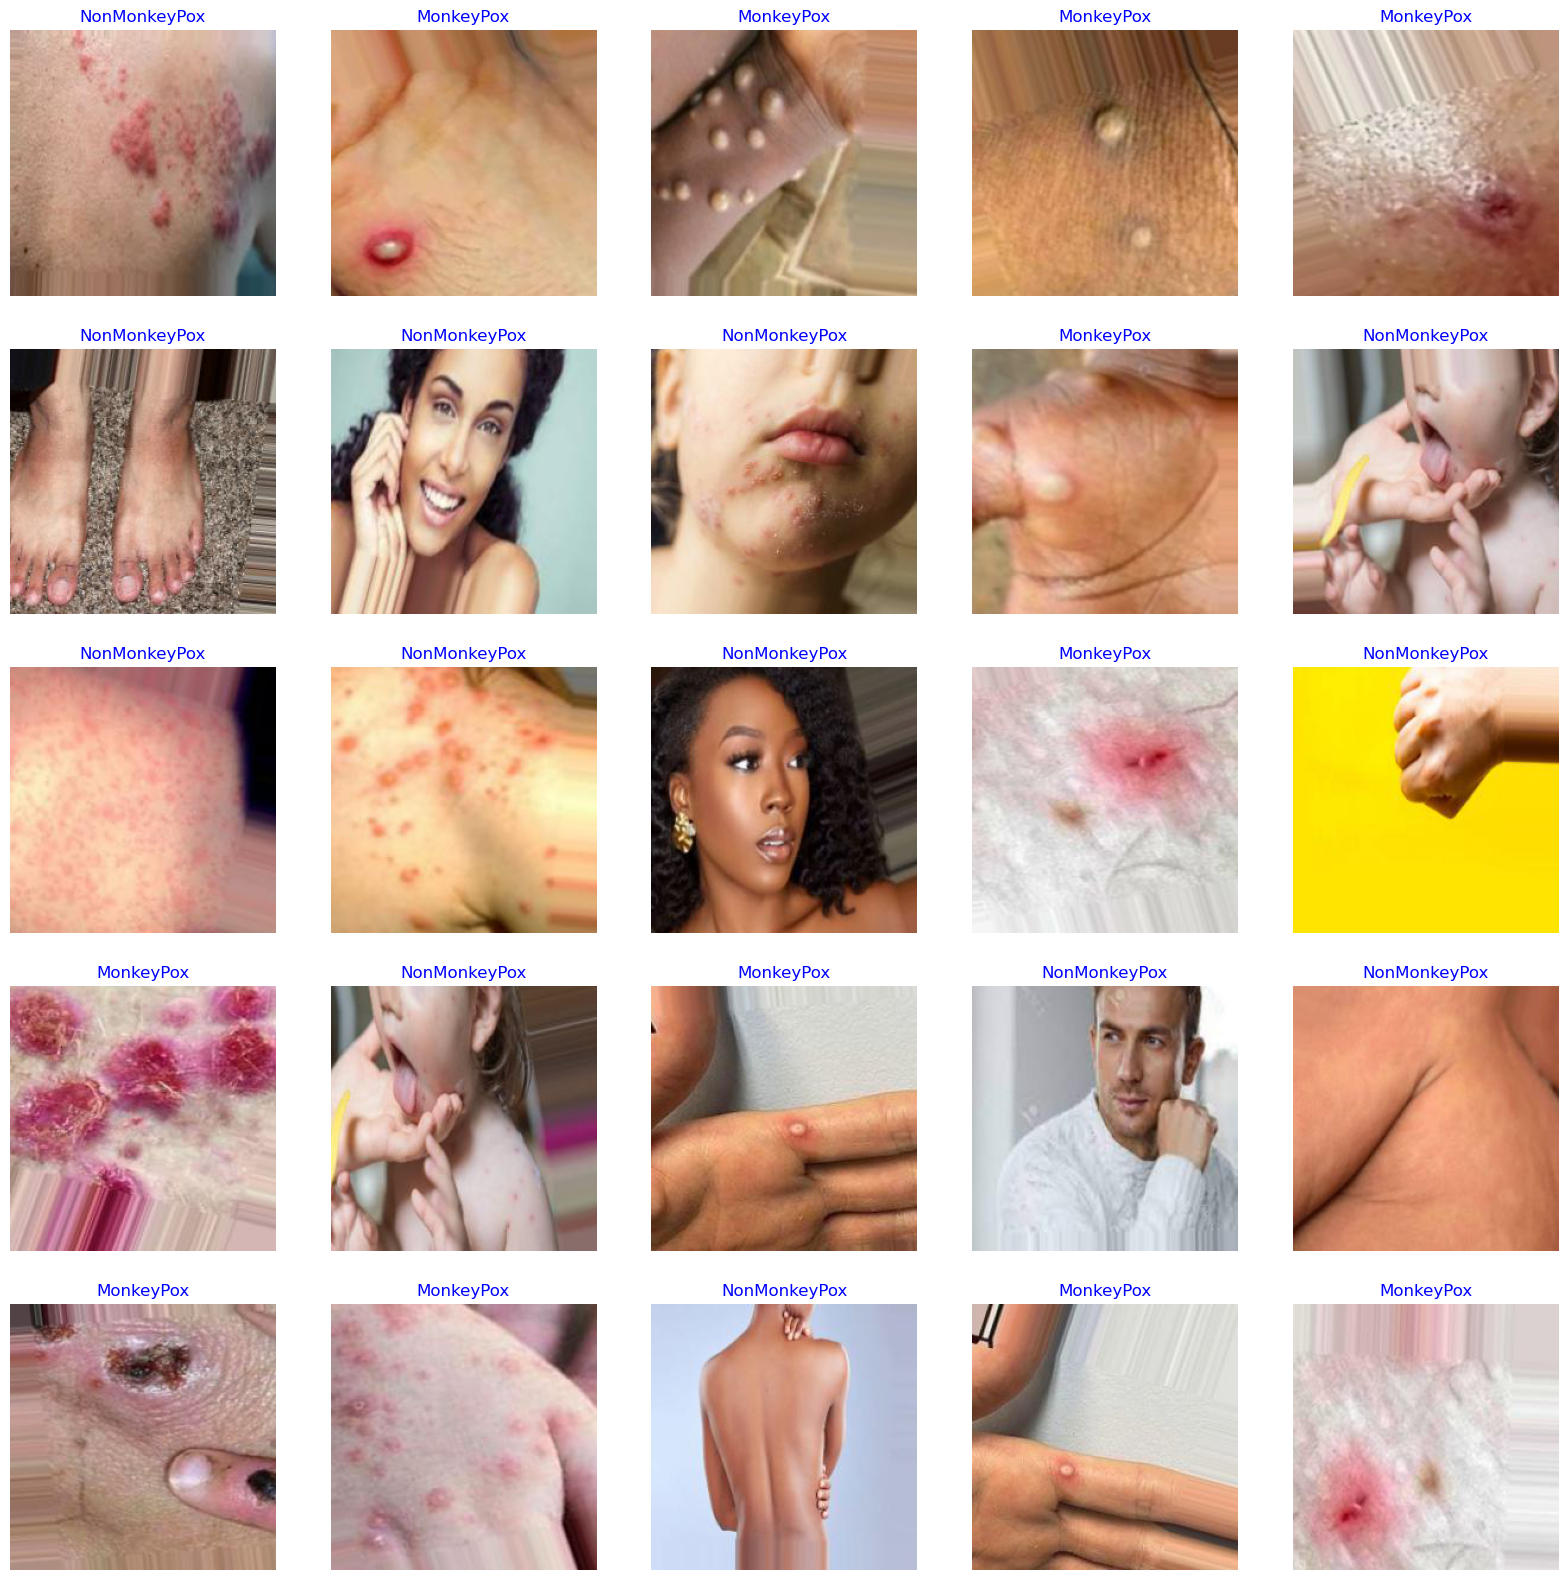

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset directory
tpath = "aug"  # Example: 'data/' containing 'monkeypox' and 'nonmonkeypox'

# Create an ImageDataGenerator for rescaling without augmentation
train_gen = ImageDataGenerator(
    rescale=1. / 255,             # Normalizes the pixel values to the range [0, 1]
    validation_split=0.2          # Splits 20% of the data for validation
)

# Load images from the directory for training
train_batch = train_gen.flow_from_directory(
    directory=tpath,
    target_size=(224, 224),        # Resize all images to 224x224
    batch_size=32,                 # Number of images to return in each batch
    subset='training',             # Specify as training data (80% of data)
    shuffle=True                   # Shuffle the images to randomize the batch
)

# Get class indices (which class corresponds to which folder)
g_dict = train_batch.class_indices  # Returns a dictionary like {'monkeypox': 0, 'nonmonkeypox': 1}
classes = list(g_dict.keys())       # List of class names: ['monkeypox', 'nonmonkeypox']

# Get a batch of images and labels
images, labels = next(train_batch)  # Fetch a batch of images and corresponding labels

# Determine the number of images to display (up to 30)
length = len(labels)        # Length of batch size (16 in this case)
sample = min(length, 25)    # Display up to 30 images (or batch size if smaller)

# Set up the plot for displaying images
plt.figure(figsize=(20, 20))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i]      # Image from the batch
    plt.imshow(image)      # Display the image
    index = np.argmax(labels[i])  # Get the index of the class label (0 or 1)
    class_name = classes[index]   # Get the class name ('monkeypox' or 'nonmonkeypox')
    plt.title(class_name, color='blue', fontsize=12)  # Set title to class name
    plt.axis('off')        # Hide axis for better display

plt.show()


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Create a Sequential model
VGG16_model = Sequential()

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
pretrained_model = VGG16(include_top=False,
                         input_shape=(224, 224, 3),  
                         pooling='avg',              
                         weights='imagenet')          

# Unfreeze the last 4 layers for fine-tuning
for layer in pretrained_model.layers[:-4]:
    layer.trainable = False

# Add the pre-trained VGG16 model to the Sequential model
VGG16_model.add(pretrained_model)

# Flatten the output from the pre-trained model
VGG16_model.add(Flatten())

# Add batch normalization to stabilize learning
VGG16_model.add(BatchNormalization())

# Add custom dense layers with dropout and L2 regularization
VGG16_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Reduced units, added L2
VGG16_model.add(Dropout(0.4))  # Dropout for regularization

# Output layer for 2 classes (Monkeypox/Other)
VGG16_model.add(Dense(2, activation='softmax', kernel_regularizer=l2(0.01)))

# Display the model summary
VGG16_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,578 (56.64 MB)

 Trainable params: 4,852,482 (18.51 MB)

 Non-trainable params: 9,996,096 (38.13 MB)

In [4]:
# Compile the model with a lower learning rate for fine-tuning
VGG16_model.compile(optimizer=Adam(learning_rate=0.00005), 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs = 40
history_vgg = VGG16_model.fit(
    training_data,
    validation_data=validation_data,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Save the trained model
VGG16_model.save('vgg16_finetuned.h5')

Epoch 1/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7415 - loss: 4.0029 - val_accuracy: 0.9303 - val_loss: 3.5734
Epoch 2/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.9614 - loss: 3.4698 - val_accuracy: 0.9697 - val_loss: 3.3951
Epoch 3/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9813 - loss: 3.3331 - val_accuracy: 0.9697 - val_loss: 3.2808
Epoch 4/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9937 - loss: 3.2060 - val_accuracy: 0.9818 - val_loss: 3.1641
Epoch 5/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9897 - loss: 3.1091 - val_accuracy: 0.9818 - val_loss: 3.0539
Epoch 6/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9967 - loss: 2.9861 - val_accuracy: 0.9788 - val_loss: 2.9516
Epoch 7/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9982 - loss: 2.8793 - val_accuracy: 0.9818 - val_loss: 2.8433
Epoch 8/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.9973 - loss: 2.7761 - val_accuracy: 0.9848 - v

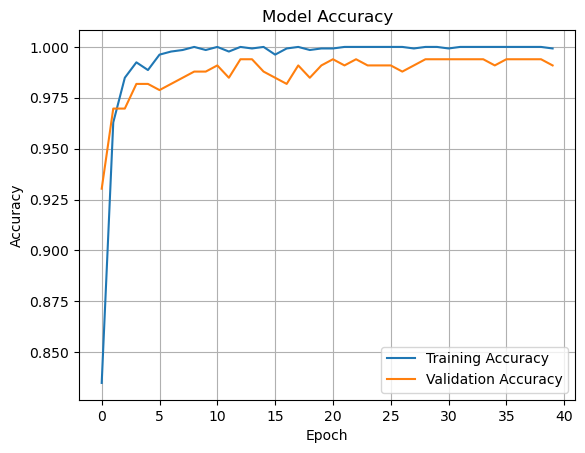

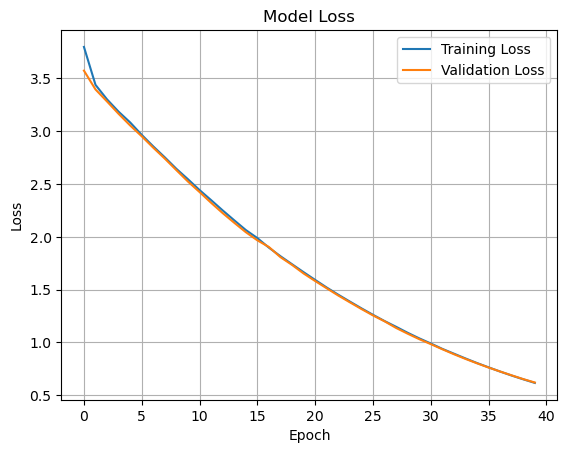

In [5]:
# Visualize training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Visualize training and validation loss
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Create a Sequential model
VGG16_model = Sequential()

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
pretrained_model = VGG16(include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='avg',
                         weights='imagenet')

# Unfreeze the last 4 layers for fine-tuning
for layer in pretrained_model.layers[:-4]:
    layer.trainable = False

# Add the pre-trained VGG16 model to the Sequential model
VGG16_model.add(pretrained_model)

# Flatten the output from the pre-trained model
VGG16_model.add(Flatten())

# Add batch normalization to stabilize learning
VGG16_model.add(BatchNormalization())

# Add custom dense layers with increased dropout and L2 regularization
VGG16_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.02)))  # Reduced units, increased L2
VGG16_model.add(Dropout(0.5))  # Increased dropout for regularization

# Output layer for 2 classes (Monkeypox/Other)
VGG16_model.add(Dense(2, activation='softmax', kernel_regularizer=l2(0.02)))

# Display the model summary
VGG16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,782,658 (56.39 MB)

 Trainable params: 4,786,562 (18.26 MB)

 Non-trainable params: 9,996,096 (38.13 MB)

In [7]:
# Compile the model with an even lower learning rate for fine-tuning
VGG16_model.compile(optimizer=Adam(learning_rate=0.00001), 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs = 45  # Increased epochs for further tuning
history_vgg = VGG16_model.fit(
    training_data,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=16,         # Lower batch size for finer updates
    callbacks=[early_stopping]
)

# Save the trained model
VGG16_model.save('vgg16_finetuned_updated.h5')

Epoch 1/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.5817 - loss: 5.1494 - val_accuracy: 0.8061 - val_loss: 4.6084
Epoch 2/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.7969 - loss: 4.6358 - val_accuracy: 0.8545 - val_loss: 4.4577
Epoch 3/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.8422 - loss: 4.5110 - val_accuracy: 0.8667 - val_loss: 4.3954
Epoch 4/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.8748 - loss: 4.3881 - val_accuracy: 0.8848 - val_loss: 4.3435
Epoch 5/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9053 - loss: 4.3281 - val_accuracy: 0.9061 - val_loss: 4.2942
Epoch 6/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9274 - loss: 4.2832 - val_accuracy: 0.9182 - val_loss: 4.2564
Epoch 7/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9496 - loss: 4.2057 - val_accuracy: 0.9273 - val_loss: 4.2193
Epoch 8/45
42/42 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9377 - loss: 4.2010 - val_accuracy: 0.9364 - v

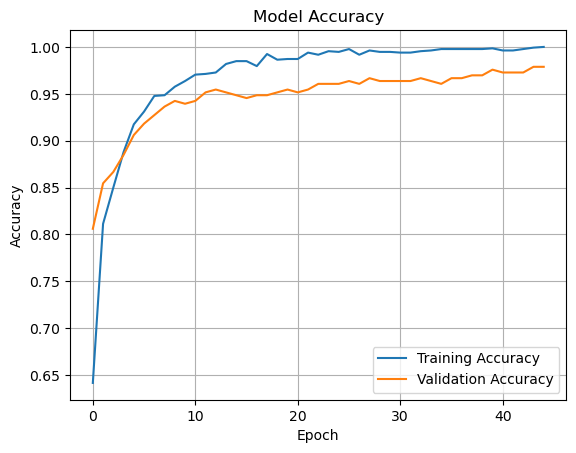

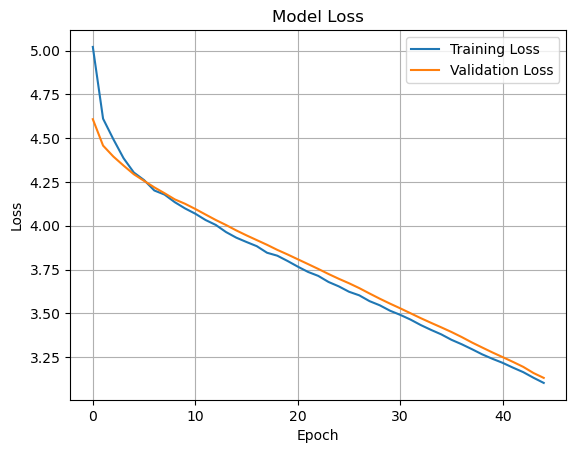

In [8]:
# Visualize training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Visualize training and validation loss
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()